In [91]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import pickle



In [92]:
destinations_df = pd.read_csv("/kaggle/input/travel-recommendation-dataset/Expanded_Destinations.csv")
reviews_df = pd.read_csv("/kaggle/input/travel-recommendation-dataset/Final_Updated_Expanded_Reviews.csv")
userhistory_df = pd.read_csv("/kaggle/input/travel-recommendation-dataset/Final_Updated_Expanded_UserHistory.csv")
users_df = pd.read_csv("/kaggle/input/travel-recommendation-dataset/Final_Updated_Expanded_Users.csv")

In [93]:
total_users = len(users_df)
print(f"Total number of users: {total_users}")

total_destinations = len(destinations_df)
print(f"Total number of destinations: {total_destinations}")

destination_types = destinations_df['Type'].unique()
print(f"Destination types: {destination_types}")

states = destinations_df['State'].unique()
print(f"States: {states}")

Total number of users: 999
Total number of destinations: 1000
Destination types: ['Historical' 'Beach' 'City' 'Nature' 'Adventure']
States: ['Uttar Pradesh' 'Goa' 'Rajasthan' 'Kerala' 'Jammu and Kashmir']


In [94]:
def dataset_info(df, name):
    print(f"\n {name} Dataset:")
    print(df.info())
    print(df.describe())
    print("Missing values:", df.isnull().sum())
    print("Duplicates:", df.duplicated().sum())

In [95]:
dataset_info(destinations_df, "Destinations")


 Destinations Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DestinationID    1000 non-null   int64  
 1   Name             1000 non-null   object 
 2   State            1000 non-null   object 
 3   Type             1000 non-null   object 
 4   Popularity       1000 non-null   float64
 5   BestTimeToVisit  1000 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 47.0+ KB
None
       DestinationID   Popularity
count    1000.000000  1000.000000
mean      500.500000     8.513927
std       288.819436     0.567083
min         1.000000     7.504500
25%       250.750000     8.034457
50%       500.500000     8.496527
75%       750.250000     9.020769
max      1000.000000     9.499811
Missing values: DestinationID      0
Name               0
State              0
Type               0
Popularity         0
BestTime

In [96]:
dataset_info(users_df, "Users")


 Users Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   UserID            999 non-null    int64 
 1   Name              999 non-null    object
 2   Email             999 non-null    object
 3   Preferences       999 non-null    object
 4   Gender            999 non-null    object
 5   NumberOfAdults    999 non-null    int64 
 6   NumberOfChildren  999 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 54.8+ KB
None
           UserID  NumberOfAdults  NumberOfChildren
count  999.000000      999.000000        999.000000
mean   500.000000        1.504505          0.981982
std    288.530761        0.500230          0.811784
min      1.000000        1.000000          0.000000
25%    250.500000        1.000000          0.000000
50%    500.000000        2.000000          1.000000
75%    749.500000        2.000000          2.

In [97]:
dataset_info(reviews_df, "Reviews")


 Reviews Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ReviewID       999 non-null    int64 
 1   DestinationID  999 non-null    int64 
 2   UserID         999 non-null    int64 
 3   Rating         999 non-null    int64 
 4   ReviewText     999 non-null    object
dtypes: int64(4), object(1)
memory usage: 39.1+ KB
None
         ReviewID  DestinationID      UserID      Rating
count  999.000000     999.000000  999.000000  999.000000
mean   500.000000     506.392392  498.610611    3.023023
std    288.530761     285.604889  286.963411    1.419331
min      1.000000       1.000000    2.000000    1.000000
25%    250.500000     273.000000  252.000000    2.000000
50%    500.000000     501.000000  494.000000    3.000000
75%    749.500000     752.000000  747.500000    4.000000
max    999.000000    1000.000000  999.000000    5.000000
Missing

In [98]:
dataset_info(userhistory_df, "User History")


 User History Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   HistoryID         999 non-null    int64 
 1   UserID            999 non-null    int64 
 2   DestinationID     999 non-null    int64 
 3   VisitDate         999 non-null    object
 4   ExperienceRating  999 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 39.1+ KB
None
        HistoryID      UserID  DestinationID  ExperienceRating
count  999.000000  999.000000     999.000000        999.000000
mean   500.000000  497.216216     493.551552          2.904905
std    288.530761  290.579414     296.684196          1.397810
min      1.000000    1.000000       2.000000          1.000000
25%    250.500000  258.500000     236.000000          2.000000
50%    500.000000  497.000000     472.000000          3.000000
75%    749.500000  752.000000     760.500000         

In [99]:
users_df.head()

,UserID,Name,Email,Preferences,Gender,NumberOfAdults,NumberOfChildren
0,1,Kavya,kavya@example.com,"Beaches, Historical",Female,1,0
1,2,Rohan,rohan@example.com,"Nature, Adventure",Male,2,2
2,3,Kavya,kavya@example.com,"City, Historical",Female,2,0
3,4,Anika,anika@example.com,"Beaches, Historical",Female,1,0
4,5,Tanvi,tanvi@example.com,"Nature, Adventure",Female,2,2


In [100]:
destinations_df.head()

,DestinationID,Name,State,Type,Popularity,BestTimeToVisit
0,1,Taj Mahal,Uttar Pradesh,Historical,8.691906,Nov-Feb
1,2,Goa Beaches,Goa,Beach,8.605032,Nov-Mar
2,3,Jaipur City,Rajasthan,City,9.225372,Oct-Mar
3,4,Kerala Backwaters,Kerala,Nature,7.977386,Sep-Mar
4,5,Leh Ladakh,Jammu and Kashmir,Adventure,8.399822,Apr-Jun


In [101]:
reviews_df.head()

,ReviewID,DestinationID,UserID,Rating,ReviewText
0,1,178,327,2,Incredible monument!
1,2,411,783,1,Loved the beaches!
2,3,927,12,2,A historical wonder
3,4,358,959,3,Incredible monument!
4,5,989,353,2,Loved the beaches!


In [102]:
userhistory_df.head()

,HistoryID,UserID,DestinationID,VisitDate,ExperienceRating
0,1,525,760,2024-01-01,3
1,2,184,532,2024-02-15,5
2,3,897,786,2024-03-20,2
3,4,470,660,2024-01-01,1
4,5,989,389,2024-02-15,4


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


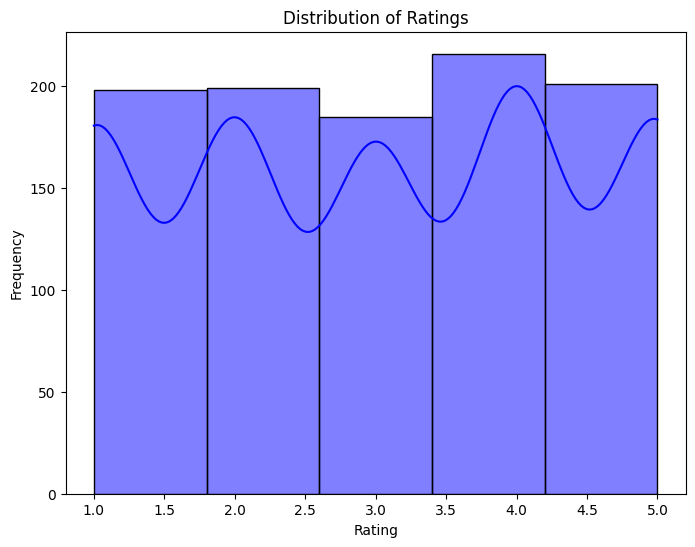

In [103]:
# Check distribution of ratings
plt.figure(figsize=(8, 6))
sns.histplot(reviews_df['Rating'], bins=5, kde=True, color='blue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

In [104]:
# Merge datasets

reviews_destinations = pd.merge(reviews_df, destinations_df, on='DestinationID', how='inner')

reviews_destinations_userhistory = pd.merge(reviews_destinations, userhistory_df, on='UserID', how='inner')

df = pd.merge(reviews_destinations_userhistory, users_df, on='UserID', how='inner')

df

,ReviewID,DestinationID_x,UserID,Rating,ReviewText,Name_x,State,Type,Popularity,BestTimeToVisit,HistoryID,DestinationID_y,VisitDate,ExperienceRating,Name_y,Email,Preferences,Gender,NumberOfAdults,NumberOfChildren
0,1,178,327,2,Incredible monument!,Jaipur City,Rajasthan,City,8.544352,Oct-Mar,79,175,2024-01-01,3,Pooja,pooja@example.com,"City, Historical",Female,1,1
1,2,411,783,1,Loved the beaches!,Taj Mahal,Uttar Pradesh,Historical,8.284127,Nov-Feb,834,894,2024-03-20,2,Karan,karan@example.com,"City, Historical",Male,1,1
2,4,358,959,3,Incredible monument!,Jaipur City,Rajasthan,City,7.738761,Oct-Mar,998,660,2024-02-15,4,Ritvik,ritvik@example.com,"Nature, Adventure",Male,1,1
3,5,989,353,2,Loved the beaches!,Kerala Backwaters,Kerala,Nature,8.208088,Sep-Mar,202,894,2024-01-01,5,Isha,isha@example.com,"Nature, Adventure",Female,2,0
4,6,473,408,4,A historical wonder,Jaipur City,Rajasthan,City,8.138558,Oct-Mar,331,403,2024-01-01,2,Ishaan,ishaan@example.com,"City, Historical",Male,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,991,701,850,3,Incredible monument!,Taj Mahal,Uttar Pradesh,Historical,8.814029,Nov-Feb,138,131,2024-03-20,1,Hitesh,hitesh@example.com,"Beaches, Historical",Male,2,0
989,991,701,850,3,Incredible monument!,Taj Mahal,Uttar Pradesh,Historical,8.814029,Nov-Feb,643,761,2024-01-01,4,Hitesh,hitesh@example.com,"Beaches, Historical",Male,2,0
990,995,231,346,5,Loved the beaches!,Taj Mahal,Uttar Pradesh,Historical,7.788256,Nov-Feb,454,113,2024-01-01,2,Hitesh,hitesh@example.com,"Beaches, Historical",Male,2,2
991,995,231,346,5,Loved the beaches!,Taj Mahal,Uttar Pradesh,Historical,7.788256,Nov-Feb,556,128,2024-01-01,4,Hitesh,hitesh@example.com,"Beaches, Historical",Male,2,2


In [105]:
df.shape

(993, 20)

In [106]:
df.duplicated().sum()

0

In [107]:
df.isnull().sum()

ReviewID            0
DestinationID_x     0
UserID              0
Rating              0
ReviewText          0
Name_x              0
State               0
Type                0
Popularity          0
BestTimeToVisit     0
HistoryID           0
DestinationID_y     0
VisitDate           0
ExperienceRating    0
Name_y              0
Email               0
Preferences         0
Gender              0
NumberOfAdults      0
NumberOfChildren    0
dtype: int64

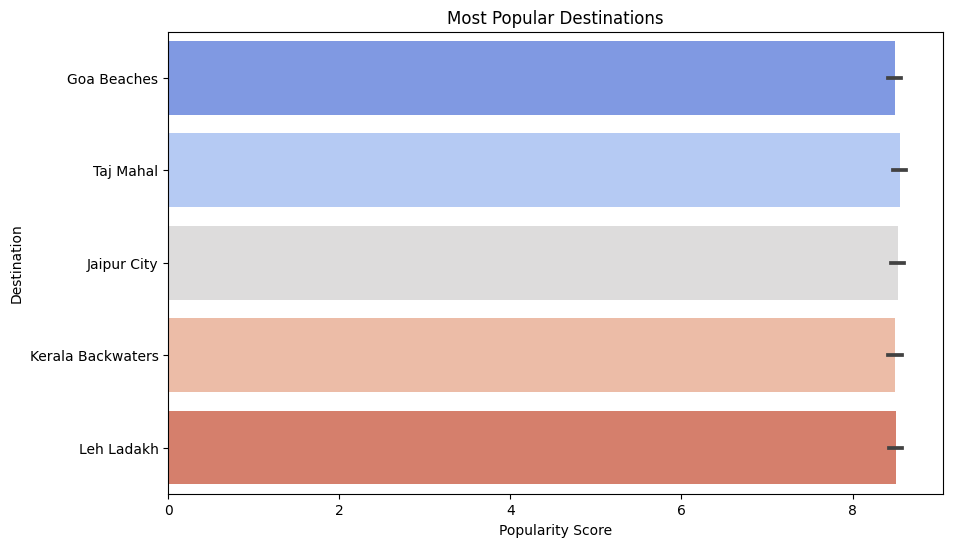

In [108]:
plt.figure(figsize=(10, 6))
sns.barplot(y='Name', x='Popularity', data=destinations_df.sort_values(by='Popularity', ascending=True), palette='coolwarm')
plt.title('Most Popular Destinations')
plt.xlabel('Popularity Score')
plt.ylabel('Destination')
plt.show()

In [109]:
destinations_df['Type'].value_counts()

Type
Historical    200
Beach         200
City          200
Nature        200
Adventure     200
Name: count, dtype: int64

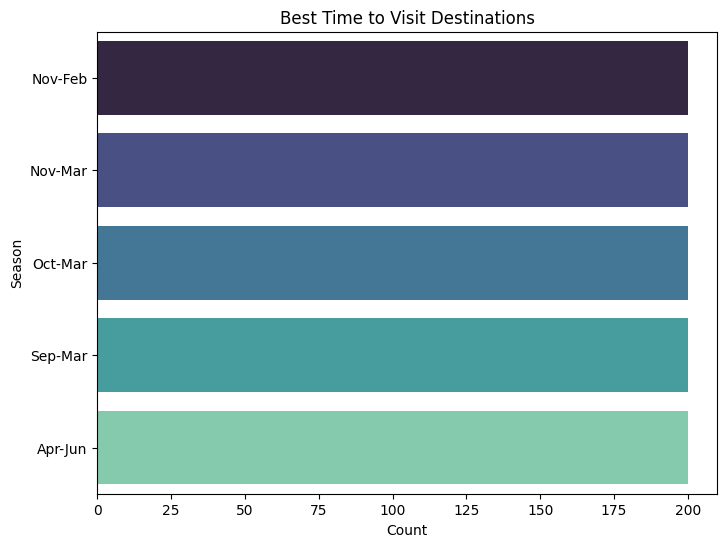

In [110]:
plt.figure(figsize=(8, 6))
sns.countplot(y='BestTimeToVisit', data=destinations_df, order=destinations_df['BestTimeToVisit'].value_counts().index, palette='mako')
plt.title('Best Time to Visit Destinations')
plt.xlabel('Count')
plt.ylabel('Season')
plt.show()

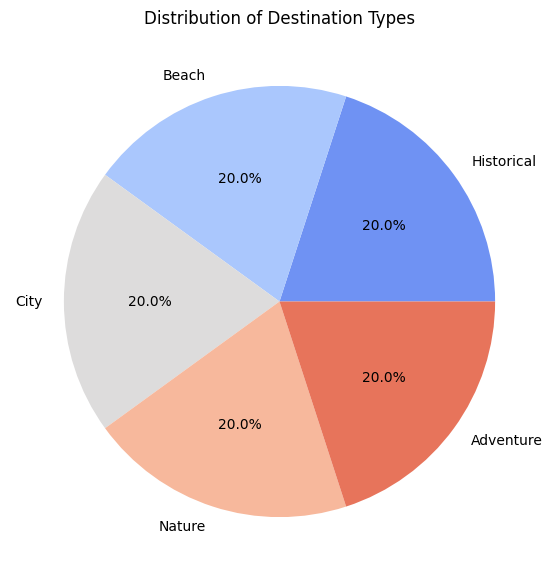

In [111]:
plt.figure(figsize=(7, 7))
destinations_df['Type'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette('coolwarm', n_colors=len(destinations_df['Type'].unique())))
plt.title('Distribution of Destination Types')
plt.ylabel('')  # Hides the y-axis label
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


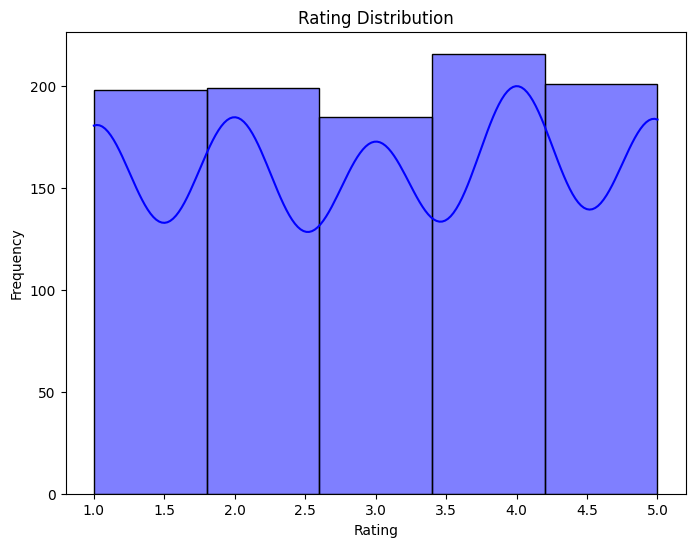

In [112]:
plt.figure(figsize=(8, 6))
sns.histplot(reviews_df['Rating'], bins=5, kde=True, color='blue')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

In [113]:
df

,ReviewID,DestinationID_x,UserID,Rating,ReviewText,Name_x,State,Type,Popularity,BestTimeToVisit,HistoryID,DestinationID_y,VisitDate,ExperienceRating,Name_y,Email,Preferences,Gender,NumberOfAdults,NumberOfChildren
0,1,178,327,2,Incredible monument!,Jaipur City,Rajasthan,City,8.544352,Oct-Mar,79,175,2024-01-01,3,Pooja,pooja@example.com,"City, Historical",Female,1,1
1,2,411,783,1,Loved the beaches!,Taj Mahal,Uttar Pradesh,Historical,8.284127,Nov-Feb,834,894,2024-03-20,2,Karan,karan@example.com,"City, Historical",Male,1,1
2,4,358,959,3,Incredible monument!,Jaipur City,Rajasthan,City,7.738761,Oct-Mar,998,660,2024-02-15,4,Ritvik,ritvik@example.com,"Nature, Adventure",Male,1,1
3,5,989,353,2,Loved the beaches!,Kerala Backwaters,Kerala,Nature,8.208088,Sep-Mar,202,894,2024-01-01,5,Isha,isha@example.com,"Nature, Adventure",Female,2,0
4,6,473,408,4,A historical wonder,Jaipur City,Rajasthan,City,8.138558,Oct-Mar,331,403,2024-01-01,2,Ishaan,ishaan@example.com,"City, Historical",Male,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,991,701,850,3,Incredible monument!,Taj Mahal,Uttar Pradesh,Historical,8.814029,Nov-Feb,138,131,2024-03-20,1,Hitesh,hitesh@example.com,"Beaches, Historical",Male,2,0
989,991,701,850,3,Incredible monument!,Taj Mahal,Uttar Pradesh,Historical,8.814029,Nov-Feb,643,761,2024-01-01,4,Hitesh,hitesh@example.com,"Beaches, Historical",Male,2,0
990,995,231,346,5,Loved the beaches!,Taj Mahal,Uttar Pradesh,Historical,7.788256,Nov-Feb,454,113,2024-01-01,2,Hitesh,hitesh@example.com,"Beaches, Historical",Male,2,2
991,995,231,346,5,Loved the beaches!,Taj Mahal,Uttar Pradesh,Historical,7.788256,Nov-Feb,556,128,2024-01-01,4,Hitesh,hitesh@example.com,"Beaches, Historical",Male,2,2


In [114]:
df['features'] = df['Type'] + ' ' + df['State'] + ' ' + df['BestTimeToVisit'] + " " + df['Preferences']
df

,ReviewID,DestinationID_x,UserID,Rating,ReviewText,Name_x,State,Type,Popularity,BestTimeToVisit,...,DestinationID_y,VisitDate,ExperienceRating,Name_y,Email,Preferences,Gender,NumberOfAdults,NumberOfChildren,features
0,1,178,327,2,Incredible monument!,Jaipur City,Rajasthan,City,8.544352,Oct-Mar,...,175,2024-01-01,3,Pooja,pooja@example.com,"City, Historical",Female,1,1,"City Rajasthan Oct-Mar City, Historical"
1,2,411,783,1,Loved the beaches!,Taj Mahal,Uttar Pradesh,Historical,8.284127,Nov-Feb,...,894,2024-03-20,2,Karan,karan@example.com,"City, Historical",Male,1,1,"Historical Uttar Pradesh Nov-Feb City, Historical"
2,4,358,959,3,Incredible monument!,Jaipur City,Rajasthan,City,7.738761,Oct-Mar,...,660,2024-02-15,4,Ritvik,ritvik@example.com,"Nature, Adventure",Male,1,1,"City Rajasthan Oct-Mar Nature, Adventure"
3,5,989,353,2,Loved the beaches!,Kerala Backwaters,Kerala,Nature,8.208088,Sep-Mar,...,894,2024-01-01,5,Isha,isha@example.com,"Nature, Adventure",Female,2,0,"Nature Kerala Sep-Mar Nature, Adventure"
4,6,473,408,4,A historical wonder,Jaipur City,Rajasthan,City,8.138558,Oct-Mar,...,403,2024-01-01,2,Ishaan,ishaan@example.com,"City, Historical",Male,2,0,"City Rajasthan Oct-Mar City, Historical"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,991,701,850,3,Incredible monument!,Taj Mahal,Uttar Pradesh,Historical,8.814029,Nov-Feb,...,131,2024-03-20,1,Hitesh,hitesh@example.com,"Beaches, Historical",Male,2,0,"Historical Uttar Pradesh Nov-Feb Beaches, Hist..."
989,991,701,850,3,Incredible monument!,Taj Mahal,Uttar Pradesh,Historical,8.814029,Nov-Feb,...,761,2024-01-01,4,Hitesh,hitesh@example.com,"Beaches, Historical",Male,2,0,"Historical Uttar Pradesh Nov-Feb Beaches, Hist..."
990,995,231,346,5,Loved the beaches!,Taj Mahal,Uttar Pradesh,Historical,7.788256,Nov-Feb,...,113,2024-01-01,2,Hitesh,hitesh@example.com,"Beaches, Historical",Male,2,2,"Historical Uttar Pradesh Nov-Feb Beaches, Hist..."
991,995,231,346,5,Loved the beaches!,Taj Mahal,Uttar Pradesh,Historical,7.788256,Nov-Feb,...,128,2024-01-01,4,Hitesh,hitesh@example.com,"Beaches, Historical",Male,2,2,"Historical Uttar Pradesh Nov-Feb Beaches, Hist..."


In [115]:
vectorizer = CountVectorizer(stop_words='english')
destination_features = vectorizer.fit_transform(df['features'])

In [116]:
destination_features.toarray()

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 0, 0]])

In [117]:
cosine_sim = cosine_similarity(destination_features, destination_features)

In [118]:
cosine_sim

array([[1.        , 0.47140452, 0.72168784, ..., 0.23570226, 0.23570226,
        1.        ],
       [0.47140452, 1.        , 0.13608276, ..., 0.88888889, 0.88888889,
        0.47140452],
       [0.72168784, 0.13608276, 1.        , ..., 0.        , 0.        ,
        0.72168784],
       ...,
       [0.23570226, 0.88888889, 0.        , ..., 1.        , 1.        ,
        0.23570226],
       [0.23570226, 0.88888889, 0.        , ..., 1.        , 1.        ,
        0.23570226],
       [1.        , 0.47140452, 0.72168784, ..., 0.23570226, 0.23570226,
        1.        ]])

In [119]:
df['features']

0                City Rajasthan Oct-Mar City, Historical
1      Historical Uttar Pradesh Nov-Feb City, Historical
2               City Rajasthan Oct-Mar Nature, Adventure
3                Nature Kerala Sep-Mar Nature, Adventure
4                City Rajasthan Oct-Mar City, Historical
                             ...                        
988    Historical Uttar Pradesh Nov-Feb Beaches, Hist...
989    Historical Uttar Pradesh Nov-Feb Beaches, Hist...
990    Historical Uttar Pradesh Nov-Feb Beaches, Hist...
991    Historical Uttar Pradesh Nov-Feb Beaches, Hist...
992              City Rajasthan Oct-Mar City, Historical
Name: features, Length: 993, dtype: object

In [120]:
def recommend_destinations(user_id, userhistory_df, destinations_df, cosine_sim):
    """
    Recommends top 5 destinations for a given user based on similarity scores.

    Args:
    - user_id: ID of the user.
    - userhistory_df: User history DataFrame containing 'UserID' and 'DestinationID'.
    - destinations_df: Destinations DataFrame containing destination details.
    - cosine_sim: Cosine similarity matrix for destinations.

    Returns:
    - DataFrame with recommended destinations and their details.
    """
    # Get the destinations the user has visited
    visited_destinations = userhistory_df[userhistory_df['UserID'] == user_id]['DestinationID'].values

    # Calculate similarity scores for visited destinations
    similar_scores = np.sum(cosine_sim[visited_destinations - 1], axis=0)

    # Recommend the top 5 destinations the user hasn't visited yet
    recommended_destinations_idx = np.argsort(similar_scores)[::-1]

    recommendations = []
    for idx in recommended_destinations_idx:
        if destinations_df.iloc[idx]['DestinationID'] not in visited_destinations:
            # Append detailed information for each recommendation
            recommendations.append(destinations_df.iloc[idx][[
                'DestinationID', 'Name', 'State', 'Type', 'Popularity', 'BestTimeToVisit'
            ]].to_dict())
        if len(recommendations) >= 5:
            break

    # Convert recommendations to a DataFrame
    return pd.DataFrame(recommendations)

# Example: Recommend destinations for user with ID 1
recommended_destinations = recommend_destinations(5, userhistory_df, destinations_df, cosine_sim)

# Display recommendations
recommended_destinations

,DestinationID,Name,State,Type,Popularity,BestTimeToVisit
0,327,Goa Beaches,Goa,Beach,8.382390,Nov-Mar
1,633,Jaipur City,Rajasthan,City,8.038341,Oct-Mar
2,560,Leh Ladakh,Jammu and Kashmir,Adventure,9.252519,Apr-Jun
3,886,Taj Mahal,Uttar Pradesh,Historical,7.713067,Nov-Feb
4,584,Kerala Backwaters,Kerala,Nature,7.877126,Sep-Mar


In [121]:
# Example: Recommend destinations for user with ID 1
recommended_destinations = recommend_destinations(2, userhistory_df, destinations_df, cosine_sim)

# Display recommendations
recommended_destinations

,DestinationID,Name,State,Type,Popularity,BestTimeToVisit
0,595,Leh Ladakh,Jammu and Kashmir,Adventure,9.446618,Apr-Jun
1,37,Goa Beaches,Goa,Beach,8.874758,Nov-Mar
2,884,Kerala Backwaters,Kerala,Nature,9.241445,Sep-Mar
3,737,Goa Beaches,Goa,Beach,9.413701,Nov-Mar
4,882,Goa Beaches,Goa,Beach,8.449238,Nov-Mar


In [122]:
user_item_matrix = userhistory_df.pivot(index='UserID', columns='DestinationID', values='ExperienceRating')
user_item_matrix = user_item_matrix.fillna(0)
user_item_matrix


DestinationID,2,3,4,5,6,7,8,9,10,11,...,987,988,990,991,993,994,996,997,998,1000
UserID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [123]:
user_similarity = cosine_similarity(user_item_matrix)
user_similarity

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [124]:
def collaborative_recommend(user_id, user_similarity, user_item_matrix, destinations_df):
    """
    Recommends destinations based on collaborative filtering.

    Args:
    - user_id: ID of the user for whom recommendations are to be made.
    - user_similarity: Cosine similarity matrix for users.
    - user_item_matrix: User-item interaction matrix (e.g., ratings or preferences).
    - destinations_df: DataFrame containing destination details.

    Returns:
    - DataFrame with recommended destinations and their details.
    """
    # Find similar users
    similar_users = user_similarity[user_id - 1]

    # Get the top 5 most similar users
    similar_users_idx = np.argsort(similar_users)[::-1][1:6]

    # Get the destinations liked by similar users
    similar_user_ratings = user_item_matrix.iloc[similar_users_idx].mean(axis=0)

    # Recommend the top 5 destinations
    recommended_destinations_ids = similar_user_ratings.sort_values(ascending=False).head(5).index

    # Filter the destinations DataFrame to include detailed information
    recommendations = destinations_df[destinations_df['DestinationID'].isin(recommended_destinations_ids)][[
        'DestinationID', 'Name', 'State', 'Type', 'Popularity', 'BestTimeToVisit'
    ]]

    return recommendations

# Example: Collaborative recommendations for user 1
collaborative_recommendations = collaborative_recommend(10, user_similarity, user_item_matrix, destinations_df)

# Display recommendations
collaborative_recommendations

,DestinationID,Name,State,Type,Popularity,BestTimeToVisit
519,520,Leh Ladakh,Jammu and Kashmir,Adventure,8.521876,Apr-Jun
524,525,Leh Ladakh,Jammu and Kashmir,Adventure,8.090624,Apr-Jun
684,685,Leh Ladakh,Jammu and Kashmir,Adventure,7.598827,Apr-Jun
755,756,Taj Mahal,Uttar Pradesh,Historical,8.547608,Nov-Feb
784,785,Leh Ladakh,Jammu and Kashmir,Adventure,9.366933,Apr-Jun


In [125]:
collaborative_recommendations = collaborative_recommend(11, user_similarity, user_item_matrix, destinations_df)

# Display recommendations
collaborative_recommendations

,DestinationID,Name,State,Type,Popularity,BestTimeToVisit
5,6,Taj Mahal,Uttar Pradesh,Historical,7.648950,Nov-Feb
367,368,Jaipur City,Rajasthan,City,8.008252,Oct-Mar
519,520,Leh Ladakh,Jammu and Kashmir,Adventure,8.521876,Apr-Jun
784,785,Leh Ladakh,Jammu and Kashmir,Adventure,9.366933,Apr-Jun
969,970,Leh Ladakh,Jammu and Kashmir,Adventure,9.013101,Apr-Jun


In [126]:
data=df.copy()

In [127]:
# Predicting popularity
features = ['Name_x', 'State', 'Type', 'BestTimeToVisit', 'Preferences', 'Gender', 'NumberOfAdults', 'NumberOfChildren']
target = 'Popularity'

In [128]:
data[features]

,Name_x,State,Type,BestTimeToVisit,Preferences,Gender,NumberOfAdults,NumberOfChildren
0,Jaipur City,Rajasthan,City,Oct-Mar,"City, Historical",Female,1,1
1,Taj Mahal,Uttar Pradesh,Historical,Nov-Feb,"City, Historical",Male,1,1
2,Jaipur City,Rajasthan,City,Oct-Mar,"Nature, Adventure",Male,1,1
3,Kerala Backwaters,Kerala,Nature,Sep-Mar,"Nature, Adventure",Female,2,0
4,Jaipur City,Rajasthan,City,Oct-Mar,"City, Historical",Male,2,0
...,...,...,...,...,...,...,...,...
988,Taj Mahal,Uttar Pradesh,Historical,Nov-Feb,"Beaches, Historical",Male,2,0
989,Taj Mahal,Uttar Pradesh,Historical,Nov-Feb,"Beaches, Historical",Male,2,0
990,Taj Mahal,Uttar Pradesh,Historical,Nov-Feb,"Beaches, Historical",Male,2,2
991,Taj Mahal,Uttar Pradesh,Historical,Nov-Feb,"Beaches, Historical",Male,2,2


In [129]:
for col in features:
      print(col)

Name_x
State
Type
BestTimeToVisit
Preferences
Gender
NumberOfAdults
NumberOfChildren


In [130]:
label_encoders = {}
for col in features:
    if data[col].dtype == 'object':
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le

In [131]:
data[features]

,Name_x,State,Type,BestTimeToVisit,Preferences,Gender,NumberOfAdults,NumberOfChildren
0,1,3,2,3,1,0,1,1
1,4,4,3,1,1,1,1,1
2,1,3,2,3,2,1,1,1
3,2,2,4,4,2,0,2,0
4,1,3,2,3,1,1,2,0
...,...,...,...,...,...,...,...,...
988,4,4,3,1,0,1,2,0
989,4,4,3,1,0,1,2,0
990,4,4,3,1,0,1,2,2
991,4,4,3,1,0,1,2,2


In [132]:
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [133]:
#Train Model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

#Evaluation
y_pred = model.predict(X_test)
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred):.2f}")

Mean Squared Error: 0.30
R² Score: 0.07


In [134]:
def recommend_destinations(user_input, model, label_encoders, features, data):
    # Encode user input
    encoded_input = {}
    for feature in features:
        if feature in label_encoders:
            encoded_input[feature] = label_encoders[feature].transform([user_input[feature]])[0]
        else:
            encoded_input[feature] = user_input[feature]

    # Convert to DataFrame
    input_df = pd.DataFrame([encoded_input])

    # Predict popularity
    predicted_popularity = model.predict(input_df)[0]

    return predicted_popularity


# Example user input
user_input = {
    'Name_x': 'Jaipur City',
    'Type': 'City',
    'State': 'Rajasthan',
    'BestTimeToVisit': 'Oct-Mar',  # This might be an unseen label
    'Preferences': 'City, Historical',
    'Gender': 'Female',
    'NumberOfAdults': 2,
    'NumberOfChildren': 1,
}

# Make a prediction
predicted_popularity = recommend_destinations(user_input, model, label_encoders, features, data)

# Print the predicted popularity and the recommended destination details
print(f"Predicted Popularity Score: {predicted_popularity:.2f}")

Predicted Popularity Score: 7.88


In [135]:
pickle.dump(model, open("model.pkl",'wb'))
pickle.dump(label_encoders, open("label_encoders.pkl",'wb'))
